In [30]:
acc   = tf.keras.metrics.AUC(int(len(censoring_status)/2))
acc.update_state(censoring_status[censoring_status + payoff_status == 1], 
        OUT_p_i_[censoring_status + payoff_status == 1]
        )
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.76499295>

In [87]:
#numbers = len(DATA[0])
batch_index = range(1000)
input = DATA[0][batch_index]
censoring_status = DATA[2][batch_index]
payoff_status    = DATA[3][batch_index]

OUT_h_i_ = tf.math.sigmoid(path_1(inputs = input)[:,-1, :])  #output shape (batch_size, timestep, 1)
OUT_p_i_ = path_RNN(inputs = input) 
censoring_status = DATA[2][batch_index]
payoff_status    = DATA[3][batch_index]

p_il, S_t = Prob_Surv(batch_index, DATA[0], MASK[0], OUT_h_i_, RNN_net = True)
loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status, alpha = 0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=2012.3842>

# Deep Mixture Cure Model
# Contents
<a href='#LoadingLibraries'>1. Load all neccessary libraries</a><br/>
<a href='#EDA'>2. Explanatory Data Analysis</a><br/>
<a href='#ChooseFeatures'>3. Choose Features from Earlier Section or External Files</a><br/>
<a href='#ImputeWinsorizeStandardize'>4. Imputation, Winsorization, Standardization</a><br/>
<a href='#TrainTestModels'>5. Train & Test the Models</a><br/>
<a href='#FeatureAnalysis'>6. Analyze Model Features Importance and their Correlation</a><br/>
<a href='#ScoreMapping'>7. Build Score Mapping Functions</a><br/>
<a href='#CreateModelPickle'>8. Create Deployable Pickle File</a><br/>
<a href='#ModelComparison'>9. Compare Model Scores against each other</a><br/>
<a href='#AnalyzeFilter'>10. Analyze the impact of various filters on training data</a><br/>
<a href='#FeatureSelectionGAXGBoost'>11. Feature Selection via Genetic Algorithm - xgboost</a><br/>
<a href='#FeatureSelectionGAXLogReg'>12. Feature Selection via Genetic Algorithm - logreg </a><br/>

# Load all neccessary libraries and data<a id='LoadingLibraries'></a>

In [1]:
import pandas as pd
import numpy as np
import lifelines
from lifelines.utils import to_long_format

# Explanatory Analysis of Data<a id='EDA'></a>

In [2]:
loan_m = pd.read_csv('../mortgage/mortgage.csv')
loan_m['loan_time'] = loan_m.time - loan_m.orig_time
loan_m['label'] = [l if l == 1 else 0 for l in loan_m['status_time'] ]
loan_m['payoff_label'] = loan_m['payoff_time']

100
60


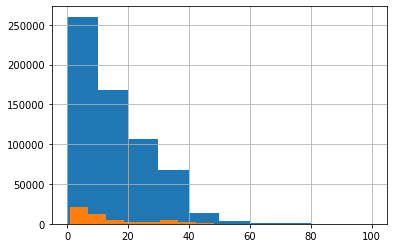

In [3]:
loan_m['loan_time'].hist()
print(loan_m['loan_time'].max())

loan_m.groupby('id').count().time.hist()
print(loan_m.groupby('id').count().time.max())  

#the max Y_x we could have, we have data until month 100, but Y_max 72, predit the survival in next 6 years at monthly rate.

In [4]:
cox_var = [var for var in loan_m.columns if not var in ['time', 'orig_time', 'first_time', 'mat_time',
'payoff_time', 'status_time', 'loan_time','label', 'default_time', 'payoff_label']]
print(cox_var)
orig_var = [ 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']
varying_co = ['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time']

['id', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']


In [5]:
# prepare data for cox_regression without varying data
data_cox = loan_m[orig_var + ['id']]
data_cox = data_cox.groupby('id').median()
duration = loan_m.groupby('id').agg({'time':'count', 'status_time': 'max'}).reset_index()
duration.columns = ['id', 'duration', 'label']
data_cox = pd.merge(data_cox, duration, on = 'id', how = 'left')
data_cox['label'] = [1 if l == 1 else 0 for l in data_cox['label'] ]

<AxesSubplot:xlabel='timeline'>

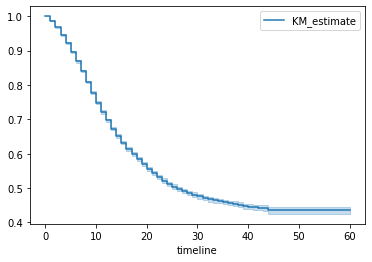

In [6]:
# kaplan cureve
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data_cox["duration"]
E = data_cox["label"]

kmf.fit(T, event_observed=E)
kmf.plot()

In [7]:
from data_preprocess import *
feature_list = varying_co

In [8]:
data_process = preprocess_data(data_original =loan_m[loan_m.id < 20001], feature_list = feature_list,)

In [9]:
DATA, MASK, data_mi, pat_info = data_process.preprocess()

In [10]:
DATA[0].shape

(20000, 51, 7)

# RNN 

In [11]:
# first neural network with keras tutorial
import tensorflow as tf
from tensorflow import keras as keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from datetime import datetime


In [12]:
from utils_layer import *
n_timesteps =  DATA[0].shape[1]
print(n_timesteps)

l_RNN = RNN_layer(n_timesteps = n_timesteps, n_features = 7, rnn_units = n_timesteps, n_layer_rnn = 2)
IN_ = tf.keras.Input(shape=(n_timesteps, 7))

51


In [13]:
outputs_1 = Sequential(l_RNN)(IN_)
x = attention()(outputs_1)
FNN = Sequential(FNN_layer(128, n_layer_dense = 1, activation_fn_dense = None, 
drop = True, r_drop = 0.4))
x = FNN(x)
outputs_2 = Dense(n_timesteps, activation='softmax', trainable=True)(x)
# build path to get sequence output and pi
M = keras.Model(inputs = IN_, outputs = [outputs_1, outputs_2])

In [14]:
M.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 51, 7)]           0         
_________________________________________________________________
sequential (Sequential)      (None, 51, 51)            33048     
_________________________________________________________________
attention (attention)        (None, 51)                102       
_________________________________________________________________
sequential_1 (Sequential)    multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 51)                2652      
Total params: 35,802
Trainable params: 35,802
Non-trainable params: 0
_________________________________________________________________


In [115]:
#compute loss
#log_likelihood
def Prob_Surv(batch_index, data, mask, OUT_h_i, RNN_net = True, ):
    if RNN_net == True:
        (mask_1, mask_2, mask_3) = mask #MASK[0]
    
    mask_1 = tf.constant(mask_1[batch_index], shape = OUT_h_i.shape, dtype = 'float32')
    mask_2 = tf.constant(mask_2[batch_index], shape = OUT_h_i.shape, dtype = 'float32')
    mask_3 = tf.constant(mask_3[batch_index], shape = OUT_h_i.shape, dtype = 'float32')

    h_i = tf.reshape(tf.math.multiply(OUT_h_i, mask_1), mask_1.shape, name='h_i')
    S_t = tf.reshape(tf.math.reduce_prod(1- h_i, axis=1, keepdims=False, name='S_i'),
    (len(batch_index), 1))

    h_last = tf.reduce_sum(tf.reshape(tf.math.multiply(OUT_h_i, mask_2), mask_2.shape), axis = 1) 
    # shape (batch_size, 1) unwanted points == 0
    mul_h = tf.math.reduce_prod(1- tf.math.multiply(OUT_h_i, mask_3, mask_3.shape,), axis=1)  # (50, 1)
    p_il = tf.reshape(tf.math.multiply(h_last, mul_h), (len(batch_index), 1))

    return p_il, S_t

In [116]:
def loss_likelihood(p_i, Prob, S_t, 
censoring_status, payoff_status, alpha = 0.6):   # censoring case == 0
    #weigths_censored   =  
    #weigths_uncensored = 
    
    # censored data
    l_censored = tf.math.add(tf.math.subtract(1, p_i), tf.math.multiply(p_i, S_t))
    l_censored = l_censored[censoring_status == 0]
    l_censored = tf.reduce_sum(
        tf.math.log(l_censored)
        )
        
    # uncensored data, true event time z
    l_uncensored = tf.math.multiply(p_i, Prob)
    l_uncensored = l_uncensored[censoring_status == 1]
    l_uncensored = tf.reduce_sum(
        tf.math.log(l_uncensored)
        )

    l_mixture = l_censored + l_uncensored

    # punishment of t>z
    l_uncensored_2 = tf.reduce_sum(
        tf.math.log((1-S_t)[censoring_status == 1])
        )
    
    l_censored_2 = tf.reduce_sum(
        tf.math.log((S_t)[censoring_status == 0])
        )

    l_c = l_uncensored_2 + l_censored_2 
    return -(alpha*l_mixture + (1-alpha)*l_c) 

In [117]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [118]:
def train_step(batch_index, input, censoring_status, payoff_status):
    with tf.GradientTape() as tape:
        # make a prediction using the model and then calculate the
        # loss
        OUT_h_i_ = tf.math.sigmoid(path_1(inputs = input)[:,-1, :])  #output shape (batch_size, timestep, 1)
        OUT_p_i_ = path_RNN(inputs = input)  #output shape (batch_size, 1)
        p_il, S_t = Prob_Surv(batch_index, input, MASK[0], OUT_h_i_,)
        loss_1 = loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status, alpha = 0.6)
        
        #loss = tf.math.sqrt(abs(loss_1))*0.3 + loss_2*0.7
    # moniter susceptible ratio for default cases:
    acc   = tf.keras.metrics.AUC(int(len(censoring_status)/2))
    acc.update_state(censoring_status[censoring_status + payoff_status == 1], 
        OUT_p_i_[censoring_status + payoff_status == 1]
        )

    gradients = tape.gradient(loss_1, path_RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, path_RNN.trainable_variables))

    return acc.result().numpy(), loss_1.numpy()

#def test_step():


In [119]:
num_epochs = 50
train_loss_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_avg.reset_states()
    for i in range(1200):
        batch_index = range(i*15, i*15 + 15)
        input = DATA[0][batch_index]
        censoring_status = DATA[2][batch_index]
        payoff_status    = DATA[3][batch_index]

        score, loss,  = train_step(batch_index, input, censoring_status, payoff_status)

        epoch_loss_avg.update_state(loss)
        train_accuracy_results.append(score)
        train_loss_results.append(epoch_loss_avg.result())
        
        if i % 300 == 0:
            print("it {:03d}: Loss: {:.3f}, AUC: {:.3%}".format(i, epoch_loss_avg.result(), tf.math.reduce_mean(train_accuracy_results[-300:])))
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
     epoch_loss_avg.result(),
     tf.math.reduce_mean(train_accuracy_results[-15000:])))
    print('===================================')

it 000: Loss: 53.073, AUC: 62.500%
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\ZR\.virtualenvs\Deep-Mixture-Cure-Model-DMh0oeYI\lib\site-packages\tensorflow\python\keras\backend.py", line 4320, in <genexpr>
    for ta, out in zip(output_ta_t, flat_new_output))  File "C:\Users\ZR\.virtualenvs\Deep-Mixture-Cure-Model-DMh0oeYI\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
it 300: Loss: 33.215, AUC: 51.021%
it 600: Loss: 31.791, AUC: 51.558%
it 900: Loss: 33.492, AUC: 53.186%
Epoch 000: Loss: 34.148, Accuracy: 55.514%
it 000: Loss: 29.318, AUC: 66.236%
it 300: Loss: 29.470, AUC: 61.534%
it 600: Loss: 29.375, AUC: 63.911%
it 900: Loss: 31.596, AUC: 63.706%
Epoch 001: Loss: 32.631, Accuracy: 59.961%
it 000: Los

In [120]:
pd.DataFrame(train_loss_results).to_csv('RNN_loss.csv')
pd.DataFrame(train_accuracy_results).to_csv('RNN_accuracy.csv')

In [184]:
batch_index = range(-5000, 0)
input = DATA[0][batch_index]
censoring_status = DATA[2][batch_index]
payoff_status    = DATA[3][batch_index]

OUT_h_i_ = tf.math.sigmoid(path_1(inputs = input)[:,-1, :])  #output shape (batch_size, timestep, 1)
OUT_p_i_ = path_RNN(inputs = input)  #output shape (batch_size, 1)
p_il, S_t = Prob_Surv(batch_index, input, MASK[0], OUT_h_i_,)
loss_1 = loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status)

In [185]:
acc   = tf.keras.metrics.AUC(int(len(censoring_status)/2))
acc.update_state(censoring_status[censoring_status + payoff_status == 1], 
        OUT_p_i_[censoring_status + payoff_status == 1]
        )
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.8981608>

In [215]:
censoring_status[censoring_status + payoff_status == 1][:20]

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0.])

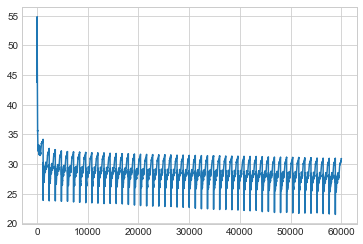

In [186]:
import matplotlib.pyplot as plt
plt.plot([i.numpy() for i in train_loss_results])

In [187]:
from lifelines.utils import concordance_index
def c_index(batch_index, OUT_h_i_, pat_info, RNN = False):
    pil_matrix = np.zeros(OUT_h_i_.shape)
    pil_matrix[:, 0] = OUT_h_i_[:, 0]
    for i in range(n_timesteps):
        if i == 0:
            pass
        else:
            temp_h = OUT_h_i_[:, i]
            temp_h_1 = tf.math.subtract(1, OUT_h_i_)[:, :i-1]
            h = tf.reduce_prod(temp_h_1, axis = 1)
            pil_matrix[:, i] = tf.math.multiply(temp_h, h).numpy()

    names = batch_index
    events = pat_info[:, 3][batch_index]
    pred_cindex = []
    preds_t = []
    for i in [12, 24, 36, 48]:
        preds = tf.math.argmax(pil_matrix[:, :i], axis = 1).numpy()
        res = concordance_index(events, preds)
        pred_cindex.append(res)
        preds_t.append(preds)
    return pred_cindex, preds_t, pil_matrix, 

In [188]:
pred_cindex, preds_t, pil_matrix = c_index(batch_index, OUT_h_i_, pat_info, RNN = False)

In [189]:
for i in [12, 24, 36, 48]:
    events = pat_info[:, 3][batch_index]
    preds = tf.math.argmax(OUT_h_i_[:, :i], axis = 1).numpy()
    print(concordance_index(events, preds))

0.38691434364182536
0.6885013014216194
0.6058292663214834
0.6586256016538997


In [190]:
x = tf.nn.softmax(pil_matrix, axis = 1)

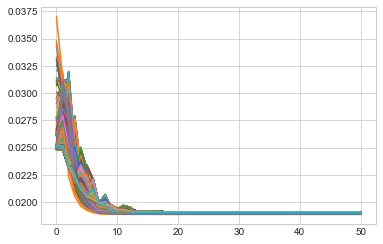

In [191]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
for i in range(len(OUT_h_i_)):
    plt.plot(range(n_timesteps), x[i,:])

10.0
[1.]


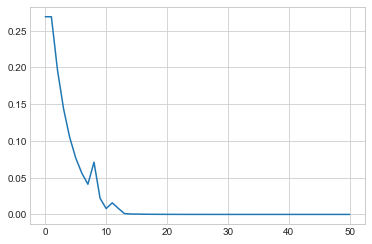

In [213]:
id = 17
plt.plot(range(n_timesteps), b[id,:])
print(pat_info[:, 3][id])
print(censoring_status[id])